# TD 2 : Implémentation d'un GAN simple

## Objective of the following tutorial : Create a simple GAN with full TF code on MNIST data

### a) Load the useful packages

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import time
import os
import pickle

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing

Check if GPU is available

In [ ]:
tf.__version__

'1.15.2'

In [ ]:
tf.test.is_gpu_available()

True

### b) Load the data

#### Description of the data: 
There are  labeled subsets of the 10 handwritten digits and consists of 70000 **28x28** grayscale images of 10 classes, with 7000 images per class. There are **60000 training images** and **10000 test images**. Source: http://yann.lecun.com/exdb/mnist/

Here, we don't need to keep the labels because it's unsupervised problem.

In [ ]:
from keras.datasets import mnist # The data can be loaded with Keras directly
(x_train, _), (_, _) = mnist.load_data()
print('x_train shape:', x_train.shape) # (#samples,height,width,#channels)
print(x_train.shape[0], 'train samples')

Using TensorFlow backend.


x_train shape: (60000, 28, 28)
60000 train samples


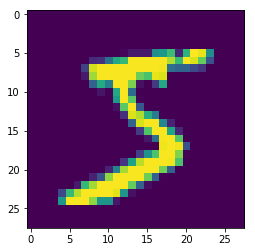

In [ ]:
plt.imshow(x_train[0])

In [ ]:
num_examples = x_train.shape[0]

### c) Preprocess the data

Here, we only need to use the all training set because it is unsupervised problem.

#### Normalize the data

###### How to normalize the data?
It will depends on the non-linear function used for the output of the generator.

In [ ]:
x_train = x_train.astype('float32')

In [ ]:
np.min(x_train)

0.0

In [ ]:
np.max(x_train)

255.0

- Normalize the images to [0, 1]:  
a) MinMax scaling :    
*We chose this way because we use a sigmoid function at the end of the generator.*

In [ ]:
x_train = (x_train) / 255

In [ ]:
np.min(x_train)

0.0

In [ ]:
np.max(x_train)

1.0

b) Standardizes a feature by subtracting the mean and then scaling to unit variance.

- Normalize the images to [-1, 1]
*This one can be chosen if the tanh activation is used.*

In [ ]:
# x_train = (x_train - 127.5) / 127.5

In [ ]:
# np.min(x_train)

In [ ]:
# np.max(x_train)

#### Reshape the input data

The shape of the input need to be reshaped for [n_samples,H*W] because we use a MLP.

In [ ]:
x_train = np.reshape(x_train, newshape = (x_train.shape[0],-1))

In [ ]:
x_train.shape

(60000, 784)

### d) Implement the model

#### i. Configuration of the two networks

Dimensions of each input of the network:

In [ ]:
dim_x=x_train.shape[1]
dim_z=100

Tools functions:

In [ ]:
def activation(name):
    if name=="relu":
        return tf.nn.relu
    elif name=="sigmoid":
        return tf.nn.sigmoid
    elif name=="leakyrelu":
        return tf.nn.leaky_relu
    elif name=="tanh":
        return tf.math.tanh
    else:
        return tf.identity

def dense(x,weight,bias,name,nonlinearity="relu",batch_norm=False,is_training=None,weight_normalization=False):   
    if nonlinearity is None:
        return tf.add(tf.matmul(x, weight), bias,name=name)
    else:
        h=tf.add(tf.matmul(x, weight), bias)
    if batch_norm:
        h=tf.layers.batch_normalization(h,training=is_training,name='bn_'+name)
    if nonlinearity=="maxout":
        return tf.contrib.layers.maxout(h,num_units=240)
    if nonlinearity=="leakyrelu":
        return activation(name=nonlinearity)(h,name=name,alpha=0.01)
    return activation(name=nonlinearity)(h,name=name)

def gaussian_layer(x,sigma): #gaussian noises
    noise = tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)
    return tf.add(x,noise)

In [ ]:
def loss_fn(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))

A simplier architecture based on https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

In [ ]:
#first no weight normalization
def discriminator(x,keep_prob=None,is_training=None,reuse=None):
    with tf.variable_scope('discriminator',reuse=reuse):
        weights = {
            'h1_w': tf.get_variable('W1', shape=(dim_x, 128), initializer=tf.contrib.layers.variance_scaling_initializer()),
            'out_w': tf.get_variable('W_out',shape=(128, 1), initializer=tf.contrib.layers.variance_scaling_initializer())
        }
        
        biases = {
            'h1_b': tf.get_variable('B1',shape=(128),initializer=tf.contrib.layers.variance_scaling_initializer()),
            'out_b': tf.get_variable('B_out',shape=(1),initializer=tf.contrib.layers.variance_scaling_initializer())
        }
        h1 = dense(x=x,weight=weights['h1_w'],bias=biases['h1_b'],name="layer1",nonlinearity="relu",weight_normalization=False,batch_norm=False,is_training=is_training)
        output = dense(x=h1,weight=weights['out_w'],bias=biases['out_b'],nonlinearity=None,name="d_output")        
        return output

In [ ]:
def generator(z,is_training=None,reuse=None):
    with tf.variable_scope('generator',reuse=reuse):
        weights = {
            'h1_w': tf.get_variable('W1', shape=(dim_z, 128), initializer=tf.contrib.layers.variance_scaling_initializer()),
            'out_w': tf.get_variable('W_out',shape=(128, dim_x), initializer=tf.contrib.layers.variance_scaling_initializer())
        }

        biases = {
            'h1_b': tf.get_variable('B1',shape=(128),initializer=tf.contrib.layers.variance_scaling_initializer()),
            'out_b': tf.get_variable('B_out',shape=(dim_x),initializer=tf.contrib.layers.variance_scaling_initializer())
        }
        h1 = dense(x=z,weight=weights['h1_w'],bias=biases['h1_b'],name="layer1",batch_norm=False,nonlinearity="relu",is_training=is_training,weight_normalization=False)
        output = dense(x=h1,weight=weights['out_w'],bias=biases['out_b'],nonlinearity="sigmoid",name="output",batch_norm=False,weight_normalization=False)
        return output

#### ii. Inputs of the Model

In [ ]:
tf.reset_default_graph()

In [ ]:
X = tf.placeholder(tf.float32,shape=[None,dim_x])
Z = tf.placeholder(tf.float32,shape=[None,dim_z])

$$Z\sim \mathbb{U}[-1,1]$$

#### iii. Hyperparameters

In [ ]:
num_epochs = 200 
batch_size = 256
learning_rate = tf.placeholder(tf.float32) #to define (0.001)
display_step = 10

#### iv.  Loss and optimizers of the model (pp.30-32)

$$\max_D L_D=\mathbb{E}_{x\sim P_{data}(x)}\big[\log p(y=1|x,D)\big]+\mathbb{E}_{z\sim P(z)}\big[\log (1-p(y=1|G(z),D))\big]$$

$$\min_G L_G=\mathbb{E}_{z\sim P(z)}\big[\log (1-p(y=1|G(z),D))\big]$$

Note that:
- a maximization problem can be transformed into a minimization problem.  
- each model has its own optimizer and learning rate => here we use the same

In [ ]:
d_real=discriminator(X)

g_sample=generator(Z)

d_fake=discriminator(g_sample,reuse=True)


d_loss_real=loss_fn(logits=d_real,
                    labels=tf.ones_like(d_real)) 
d_loss_fake=loss_fn(logits=d_fake,labels=tf.zeros_like(d_fake)) 
d_loss=d_loss_real+d_loss_fake



g_loss=loss_fn(logits=d_fake,labels=tf.ones_like(d_fake))

tvars=tf.trainable_variables()


d_vars = [var for var in tvars if 'discriminator' in var.name]
g_vars = [var for var in tvars if 'generator' in var.name]


#on peut appliquer des gradients différents
d_opt=tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(d_loss, var_list=d_vars)
g_opt=tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(g_loss, var_list=g_vars)

In [ ]:
d_pred_real=tf.nn.sigmoid(d_real)
d_pred_real=tf.cast(d_pred_real>0.5,dtype=tf.int64)
d_pred_real=tf.reshape(d_pred_real,shape=[-1])
d_pred_fake=tf.nn.sigmoid(d_fake)
d_pred_fake=tf.cast(d_pred_fake>0.5,dtype=tf.int64)
d_pred_fake=tf.reshape(d_pred_fake,shape=[-1])
pred=tf.concat([d_pred_real,d_pred_fake],axis=0)
y=tf.concat([tf.ones_like(d_pred_real,dtype=tf.int64),
             tf.zeros_like(d_pred_fake,dtype=tf.int64)],axis=0)

correct_prediction = tf.equal(pred,y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### vi. Launch the graph

- First, the discriminator is trained, then, the generator and so on.
- Pay attention of these facts (pp.40-42)
    - unstable training => vanishing gradients for the Generator
    - dropping mode => G tries both to minimize $$KL(p_m\||p_d)$$ and to maximize $$JS(p_m\||p_d)$$ 
    - mode collapse : KL divergence is an unsymmetrical distribution measure : Generated data lack the diversity

Define a save directory to save the results

In [ ]:
save_dir=os.path.join('./saved-models')
if not(os.path.isdir(save_dir)):
    os.mkdir(save_dir)
save_dir=os.path.join('./saved-models/1')
if not(os.path.isdir(save_dir)):
    os.mkdir(save_dir)

In [ ]:
# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement=True)

In [ ]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [ ]:
with tf.device("/gpu:0"):
    with tf.Session(config=config) as sess:
        sess.run(init) 
        samples=[]
        begin=time.time()
        
        #Which results we want to get
        train_loss_dis=[]
        train_loss_gen=[]
        train_acc=[]
        
        for epoch in range(num_epochs):
            
            #training part
            total_batches=num_examples//batch_size
            d_avg_cost_train, acc_avg_train,g_avg_cost_train= 0,0,0

            #Shuffling the index
            index = np.arange(x_train.shape[0])
            np.random.shuffle(index)
            batch_X = np.array_split(x_train[index], total_batches)

            for batch in range(total_batches):
                batch_x = batch_X[batch]

                batch_z=np.random.uniform(-1,1,size=(batch_size,dim_z))
          
                _,loss,acc = sess.run([d_opt,d_loss, accuracy], 
                                    feed_dict={X: batch_x,Z: batch_z, 
                                               learning_rate:0.001})
                d_avg_cost_train += loss / total_batches
                acc_avg_train += acc / total_batches

                
                _,loss = sess.run([g_opt,g_loss], 
                                    feed_dict={Z: batch_z, learning_rate:0.001})
                g_avg_cost_train += loss / total_batches
            
            train_loss_dis.append(d_avg_cost_train)
            train_loss_gen.append(g_avg_cost_train)
            train_acc.append(acc_avg_train)
                      
            if (epoch % display_step == 0 ) or epoch == 0:   
                #show the results at a display step
        
                sample_z=np.random.uniform(-1,1,size=(16,dim_z))
                #sample_z=np.random.normal(size=(16,dim_z))
                gen_sample=sess.run(g_sample,feed_dict={Z:sample_z})

                fig = plot(gen_sample)
                fig.show()
                plt.savefig(os.path.join(save_dir,'{}.png'.format(str(epoch).zfill(3))), bbox_inches='tight')
                plt.close(fig)
                
                print("Epoch {} | time = {} | loss gen = {:.4f} | loss disc = {:.4f} "
                    "| train acc = {:.4f}"
                    .format(epoch, time.time() - begin, g_avg_cost_train,
                            d_avg_cost_train, acc_avg_train))        

/nhome/siniac/vbourgeais/venv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Epoch 0 | time = 1.1383554935455322 | loss gen = 4.8167 | loss disc = 0.1913 | train acc = 0.9720
Epoch 10 | time = 8.284393072128296 | loss gen = 6.1957 | loss disc = 0.0235 | train acc = 0.9982
Epoch 20 | time = 15.513047456741333 | loss gen = 5.4860 | loss disc = 0.1671 | train acc = 0.9702
Epoch 30 | time = 23.379814863204956 | loss gen = 4.1275 | loss disc = 0.3242 | train acc = 0.9381
Epoch 40 | time = 31.416414260864258 | loss gen = 3.6431 | loss disc = 0.4593 | train acc = 0.9094
Epoch 50 | time = 38.69110631942749 | loss gen = 3.0384 | loss disc = 0.5116 | train acc = 0.8958
Epoch 60 | time = 44.84458518028259 | loss gen = 2.6841 | loss disc = 0.5823 | train acc = 0.8782
Epoch 70 | time = 51.96177649497986 | loss gen = 2.5309 | loss disc = 0.6141 | train acc = 0.8695
Epoch 80 | time = 59.35610771179199 | loss gen = 2.4211 | loss disc = 0.6414 | train acc = 0.8598
Epoch 90 | time = 67.63659811019897 | loss gen = 2.3589 | loss disc = 0.6460 | train acc = 0.8593
Epoch 100 | time 

With Google Collab, maybe we need to choose a specific directory.

#### Analyse the results

In [ ]:
vec1=[train_loss_dis[i] for i in range(len(train_loss_dis)) if (i%10==0 or i==0) and i<99]

In [ ]:
vec2=[train_loss_gen[i] for i in range(len(train_loss_gen)) if (i%10==0 or i==0) and i<99]

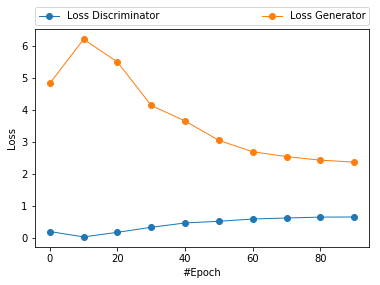

In [ ]:
epochs=np.arange(0,100,10)
plt.plot(epochs,vec1,marker='o', linestyle='solid',
             linewidth=1, markersize=6,label="Loss Discriminator")
plt.plot(epochs,vec2,marker='o', linestyle='solid',
         linewidth=1, markersize=6,label="Loss Generator")

plt.ylabel("Loss")
plt.xlabel("#Epoch")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

After the 1rst epoch:

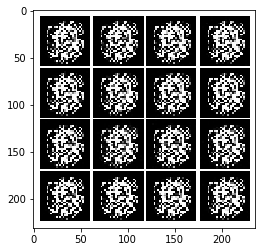

In [ ]:
import matplotlib.image as mpimg
idx=0
img=mpimg.imread(os.path.join(save_dir,'{}.png'.format(str(idx).zfill(3))))
plt.imshow(img)

After 100 epochs:

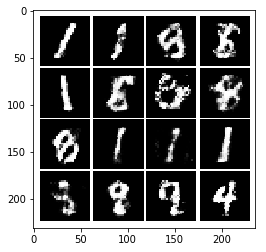

In [ ]:
import matplotlib.image as mpimg
idx=100
img=mpimg.imread(os.path.join(save_dir,'{}.png'.format(str(idx).zfill(3))))
plt.imshow(img)